In [1]:
#atmaCup#8
https://www.guruguru.science/competitions/13/

SyntaxError: invalid syntax (4076386397.py, line 2)

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings  # 警告を非表示にする

from ydata_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
warnings.filterwarnings('ignore') #警告を非表示にする

sns.set_style('ticks')

In [3]:
ls ../input/atmacup08-dataset/

test.csv  train.csv


In [3]:
train_df = pd.read_csv('../input/atmacup08-dataset/train.csv', engine='python')
test_df  = pd.read_csv('../input/atmacup08-dataset/test.csv',  engine='python')

In [4]:
train_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+


In [10]:
report = ProfileReport(train_df)
report.to_file('train_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


  0%| | 0/16 [00:00<
100%|█| 16/16 [00:00


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

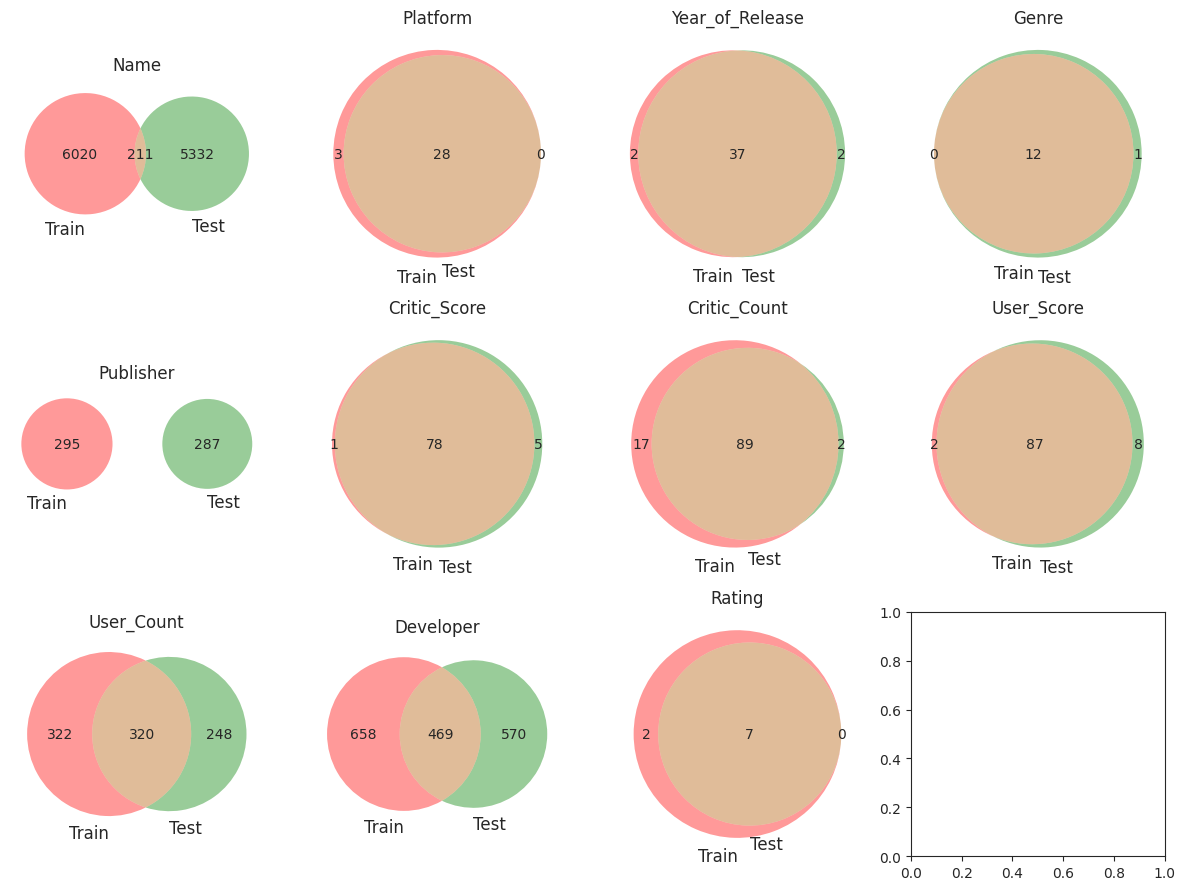

In [11]:
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [5]:
def create_continuous_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # 'tbd' を NaN にして float に変換
    df['User_Score'] = (
        df['User_Score']
        .replace('tbd', np.nan)
        .astype(float)
    )

    use_columns = [
        'Critic_Score',
        'Critic_Count',
        'User_Score',
        'User_Count',
        'Year_of_Release',
    ]
    return df[use_columns]

In [13]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [6]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()

    texts = [
        'japan', 'nintendo'
    ]

    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [7]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [8]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_boolean_feature
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [9]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|████████████████████| 2/2 [00:00<00:00, 13.65it/s]


create create_continuous_features 0.087[s]
create create_boolean_feature 0.042[s]


100%|████████████████████| 2/2 [00:00<00:00, 64.43it/s]

create create_continuous_features 0.015[s]
create create_boolean_feature 0.014[s]


In [10]:
assert len(test_feat_df) == len(test_df)

In [11]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=10):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)

        # global sales はゼロ以下になるわけがないので 0 以下は 0 に丸める
        pred_i = np.where(pred_i < 0, 0, pred_i)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {mean_squared_log_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_log_error(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [12]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values

In [13]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [14]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations